In [1]:
import keras
from Chemometrics.import_common import *
import xarray
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


~~~py
ds = xarray.open_dataset('./data/data-test/37454.cdf')
pn = int(1+ds.actual_run_time_length/ds.actual_sampling_interval)
pn == ds.dims['point_number']
# point number 是actual_run_time_length/actual_sampling_interval +1
~~~

In [2]:
#detection code encoder
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
le = LabelEncoder().fit([b'B',b'V',b'F' b'M'])
#le.transform(ds.peak_start_detection_code)
#code1 = le.transform(ds.peak_start_detection_code)
#code2 = le.transform(ds.peak_stop_detection_code)

- first layer
    - input shape  
    LSTM : (batch_size, timesteps, input_dim)  
    batch_size: number of observations  
    timestep: length of chromagraph  
    input_dim: number of features  

In [3]:
def get_peaks(file):
    #feature value unit?
    le = LabelEncoder().fit([b'B',b'V',b'F',b'M'])
    ds = xarray.open_dataset(file)
    if any(ds.peak_retention_time<1e-5):
        return None
    peaks = np.vstack([diff_rt(ds.peak_retention_time),
                       ds.peak_asymmetry,
                       ds.peak_area_percent,
                      ds.peak_height/ds.peak_width,
                      le.transform(ds.peak_start_detection_code),
                      le.transform(ds.peak_stop_detection_code)])
    return peaks.T

In [4]:
def diff_rt(peak_retention_time):
    drt = np.concatenate([[peak_retention_time[0]],np.diff(peak_retention_time)])/60
    return drt

# data feed

- target

In [5]:
import glob

In [6]:
fs = glob.glob('./data/**/优*.cdf',recursive=True)
y = ['优降一' if '优降一' in f else '优' for f in fs ]
ley = LabelEncoder()
y = ley.fit_transform(y)

- observation

In [7]:
chromagraphs,y = zip(*[(get_peaks(f),yi)  for f,yi in zip(fs,y) if get_peaks(f) is not None])

In [8]:
type(chromagraphs)

tuple

In [9]:
from keras.preprocessing import sequence

In [10]:
X = sequence.pad_sequences(chromagraphs,padding = 'post')

In [11]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

In [12]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X,np.array(y),stratify=y)

In [13]:
#手动random-sample
y_idx = np.where(y_train_>0)[0]
X_ = X_train_[np.random.choice(y_idx,sum(y_train_==0)),:,:]
Xp = X_train_[y_train_==0,:,:]
Xros = np.concatenate([Xp,X_])
yros = np.concatenate([y_train_[y_train_==0],np.ones(sum(y_train_==0))])

In [14]:
#add noise
#Xros = (np.random.random(Xros.shape)*1e-3+Xros)

In [33]:
# build and compile
np.random.seed(2)
model = Sequential()
model.add(LSTM(30,input_shape=(None,Xros[1].shape[1])))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics = ['accuracy'])
print(model.summary())
earlyStopping=keras.callbacks.EarlyStopping(
    monitor='loss', patience=3, verbose=0, mode='auto')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30)                4440      
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 4,471
Trainable params: 4,471
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
model.fit(Xros,yros,epochs=100,shuffle=True,
          validation_split=.2,callbacks=[earlyStopping],class_weight='auto')

Train on 211 samples, validate on 53 samples
Epoch 1/100
211/211 [==============================] - 1s 6ms/step - loss: 0.6913 - acc: 0.5118 - val_loss: 0.7023 - val_acc: 0.1698
Epoch 2/100
211/211 [==============================] - 0s 1ms/step - loss: 0.6806 - acc: 0.6303 - val_loss: 0.7371 - val_acc: 0.0189
Epoch 3/100
211/211 [==============================] - 0s 1ms/step - loss: 0.6659 - acc: 0.6445 - val_loss: 0.7827 - val_acc: 0.0189
Epoch 4/100
211/211 [==============================] - 0s 1ms/step - loss: 0.6548 - acc: 0.6351 - val_loss: 0.8536 - val_acc: 0.0189
Epoch 5/100
211/211 [==============================] - 0s 2ms/step - loss: 0.6465 - acc: 0.6351 - val_loss: 0.9714 - val_acc: 0.0189
Epoch 6/100
211/211 [==============================] - 0s 1ms/step - loss: 0.6396 - acc: 0.6351 - val_loss: 1.0274 - val_acc: 0.0189
Epoch 7/100
211/211 [==============================] - 0s 1ms/step - loss: 0.6288 - acc: 0.6351 - val_loss: 0.9685 - val_acc: 0.0189
Epoch 8/100
211/211 [===

In [35]:
scores = model.evaluate(X_test_,y_test_)
scores

50/50 [==============================] - 0s 421us/step


[0.8559419107437134, 0.7999999928474426]

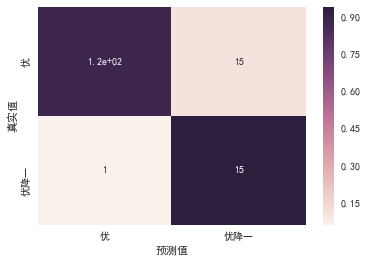

In [36]:
yt_pred = model.predict_classes(X_train_)
plot_ConfusionMatrix(confusion_matrix(y_train_,yt_pred),sorted_unique_labels=ley.classes_)

In [37]:
y_pred = model.predict_classes(X_test_)

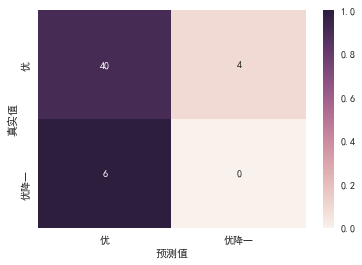

In [39]:
plot_ConfusionMatrix(confusion_matrix(y_test_,y_pred),sorted_unique_labels=ley.classes_)